In [1]:
import sys, os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import quad, nquad
from sklearn.preprocessing import normalize
from sktree.tree import DecisionTreeClassifier
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from sklearn import metrics
from hyppo import make_trunk_classification

In [2]:
SIMULATIONS = {
    "1" : {},
    "2" : {"m_factor" : 1},
    "3" : {"band_type" : "ar", "rho" : 0.5},
    "4" : {"band_type" : "ar", "m_factor" : 1, "rho" : 0.5},
}

In [3]:
def _perm_stat(est, sim, n=100, p=1, **kwargs):
    """
    Generates null and alternate distributions
    """
    est.reset()
    x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=p, **SIMULATIONS[sim],return_params = True)
    x = np.float32(x)
    y = np.float32(y)
    _,obs_stat = est.statistic(x, y,**kwargs)
    permv = np.random.permutation(y)
    est.reset()
    _,perm_stat = est.statistic(x, permv, **kwargs)
    est.reset()

    return obs_stat, perm_stat


def _nonperm_pval(est, sim, n=100, p=1, noise=True, **kwargs):
    """
    Generates fast  permutation pvalues
    """
    est.reset()
    x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=p, **SIMULATIONS[sim],return_params = True)
    x = np.float32(x)
    y = np.float32(y)
    est.reset()
    pvalue = est.test(x, y, metric = "s@98")[1]
    est.reset()
    return pvalue

In [13]:
SAMP_SIZES = [2**i for i in range(8, 10)]
SAMP_SIZES_plot = [2*2**i for i in range(8, 10)]
DIM = 4 ** 6
REPS = range(100, 1000)
P = 4096
SAVE_PATH  = '/Users/baiyuxin/Desktop/JHU/NDD/Cancer/MIGHT_POWER'


In [5]:
def compute_null(rep, est, est_name, sim, n=100, p=1):
    """
    Calculates empirical null and alternate distribution for each test.
    """
    kwargs = {}
    if est_name in ["MIGHT-sktree", "MIGHT-Coleman"]:
        kwargs = {"metric" : "mi"}
    if est_name in ["MIGHT", "MIGHT-sktree"]:
        alt_dist, null_dist = _perm_stat(est, sim, n, p)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim, est_name, n, rep), [alt_dist, null_dist], delimiter=",")
    else:
        pval = _nonperm_pval(est, sim, n, p)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim, est_name, n, rep), [pval])

In [6]:
n_jobs = -3
# test_size = 0.2
n_estimators = 500

### Calculate one dimention posterior with max_features = all, depth = 1
clf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=0.3,
        bootstrap= True,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        n_jobs=n_jobs,

    ),
    # test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=True,
    stratify = True
)



clf2 = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=0.3,
        bootstrap= True,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        n_jobs=n_jobs,

    ),
    # test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=True,
    stratify = True
)


clf3 = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=0.3,
        bootstrap= True,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        n_jobs=n_jobs,

    ),
    # test_size=test_size,
    permute_per_tree=True,
    sample_dataset_per_tree=True,
    stratify = True
)




In [11]:
clf.reset()
x,y,mu,cov = make_trunk_classification(n_samples=256, n_dim=4096, **SIMULATIONS["1"],return_params = True)
# x = np.float32(x)
# y = np.float32(y)
print(clf.statistic(x, y,metric = "s@98"))
clf.reset()

(0.5390625, 0.5390625)


In [27]:
for i in ["1","2","3"]:
  for rep in range(20):
    for sam in [1024]:
     alt_dist, null_dist = _perm_stat(est = clf, sim = i, n=sam, p=4096)
     print(alt_dist, null_dist)
     np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, i, 'MIGHT', sam, rep), [alt_dist, null_dist], delimiter=",")

0.728515625 0.009765625
0.744140625 0.02734375
0.62890625 0.03515625
0.728515625 0.015625
0.740234375 0.03515625
0.73828125 0.0234375


/Users/baiyuxin/anaconda3/envs/might/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.70703125 0.01171875
0.708984375 0.015625
0.712890625 0.021484375
0.791015625 0.017578125
0.685546875 0.01171875


/Users/baiyuxin/anaconda3/envs/might/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.712890625 0.01171875
0.671875 0.046875
0.763671875 0.00390625
0.763671875 0.01171875
0.796875 0.0234375
0.732421875 0.0234375
0.7734375 0.037109375
0.755859375 0.021484375
0.765625 0.01953125
0.017578125 0.03125
0.033203125 0.017578125
0.017578125 0.005859375
0.015625 0.017578125
0.01953125 0.017578125
0.015625 0.037109375
0.044921875 0.01171875
0.00390625 0.03125
0.013671875 0.029296875
0.017578125 0.021484375
0.01171875 0.03515625
0.0234375 0.03125
0.017578125 0.033203125
0.00390625 0.01953125
0.015625 0.01953125
0.029296875 0.005859375
0.021484375 0.025390625
0.017578125 0.029296875
0.02734375 0.005859375
0.02734375 0.013671875
0.564453125 0.01171875
0.541015625 0.017578125
0.4765625 0.021484375
0.548828125 0.029296875
0.4296875 0.021484375
0.609375 0.015625
0.384765625 0.033203125
0.51171875 0.01953125
0.48828125 0.017578125
0.4375 0.021484375


/Users/baiyuxin/anaconda3/envs/might/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.626953125 0.01953125


In [7]:
for i in ["2"]:
  for rep in range(8,50):
    for sam in SAMP_SIZES:
     pval = _nonperm_pval(est = clf2, sim = i, n=sam, p=4096)
     print(pval)
     np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, i, 'MIGH_Coleman', sam, rep), [pval], delimiter=",")

0.7222777222777222
0.8141858141858141
0.7452547452547452
0.4355644355644356
0.7402597402597403
0.002997002997002997
0.6493506493506493
0.22077922077922077
0.967032967032967
0.17882117882117882
0.7612387612387612
0.8371628371628371
0.07392607392607392
0.8201798201798202
0.11488511488511488
0.13586413586413587
0.11788211788211789
0.3006993006993007
0.24375624375624375
0.46553446553446554
0.5214785214785215
0.7012987012987013
0.6283716283716284
0.07392607392607392
0.03896103896103896
0.6483516483516484
0.16983016983016982
0.5234765234765235
0.5434565434565435


In [36]:
_nonperm_pval(est = clf3, sim = "1", n=32, p=4096)

0.8971028971028971

In [24]:
for i in ["2","3"]:
  for rep in range(20):
    for sam in [128]:
     pval = _nonperm_pval(est = clf3, sim = i, n=sam, p=4096)
     print(pval)
     np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, i, 'MIGH_Coleman_pertree', sam, rep), [pval], delimiter=",")

0.7942057942057942
0.5544455544455544
0.7932067932067932
0.12987012987012986
0.6483516483516484
0.6543456543456544
0.8621378621378621
0.986013986013986
0.000999000999000999
0.8501498501498501
0.8511488511488512
0.8111888111888111
0.5834165834165834
0.9000999000999002
0.04395604395604396
0.7122877122877123
0.5144855144855145
0.25574425574425574
0.2677322677322677
0.7632367632367633
0.000999000999000999
0.08591408591408592
0.14085914085914086
0.053946053946053944
0.000999000999000999
0.3886113886113886
0.03496503496503497
0.3956043956043956
0.029970029970029972
0.000999000999000999
0.12187812187812187
0.004995004995004995
0.000999000999000999
0.6483516483516484
0.32367632367632365
0.13786213786213786
0.000999000999000999
0.002997002997002997
0.15584415584415584
0.001998001998001998


0.1782178217821782

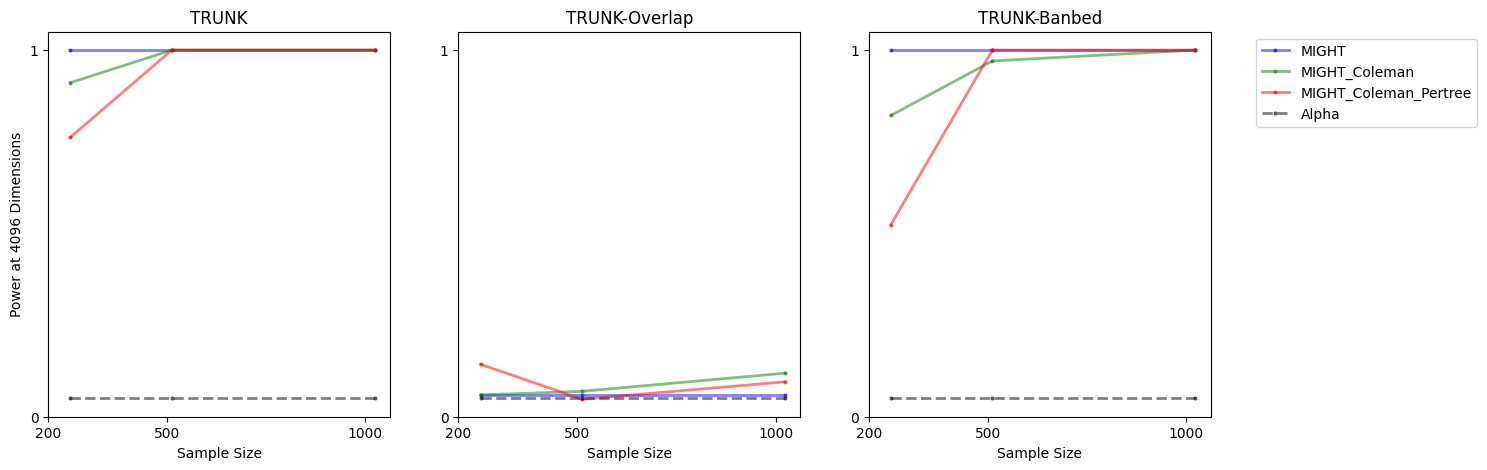

In [26]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 14))

SAMP_SIZES = [2**i for i in range(7, 10)]
SAMP_SIZES_plot = [2*2**i for i in range(7, 10)]


plt.rcParams["font.size"] = 10
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
REPs = 20
ALPHA = 0.05
for sim in ["1","2","3"]:
    power_MIGHT = []
    for n in SAMP_SIZES:
        file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim, 'MIGHT', n)
        alt_dist, null_dist = map(
                        np.float64,
                        zip(*[
                            np.genfromtxt("{}_{}.txt".format(file_name, rep))
                            for rep in range(4,REPs)
                        ]),
                    )
        cutoff = np.sort(null_dist)[math.ceil((REPs-4) * (1 - ALPHA)) - 1]
        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + (REPs-4))

        power_MIGHT.append(empirical_power)
    
    
    power_MIGHT_Coleman = []
    for n in SAMP_SIZES:
        df2 = np.genfromtxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/df2_coleman.csv",delimiter=",")[1:]
        df_sim = df2[df2[:,1]==int(sim)]
        df_samp = df_sim[df_sim[:,2]==n]
        pvals = df_samp[:,3]
        empirical_power = (1 + (pvals <= 0.05).sum()) / (1 + 100)
        power_MIGHT_Coleman.append(empirical_power)
    
    power_MIGHT_Coleman_pertree = []
    for n in SAMP_SIZES:
        file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim, 'MIGH_Coleman_pertree', n)
        pvals = np.array([np.genfromtxt("{}_{}.txt".format(file_name, rep)) for rep in range(REPs)])
        empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + REPs)
        power_MIGHT_Coleman_pertree.append(empirical_power)
    
    axs[int(sim)-1].plot(SAMP_SIZES_plot, power_MIGHT, 'blue',marker='o', markersize=2,label = "MIGHT",linewidth =2,alpha = 0.5)
    axs[int(sim)-1].plot(SAMP_SIZES_plot, power_MIGHT_Coleman, 'green',marker='o', markersize=2,label = "MIGHT_Coleman",linewidth =2,alpha = 0.5)
    axs[int(sim)-1].plot(SAMP_SIZES_plot, power_MIGHT_Coleman_pertree, 'red',marker='o', markersize=2,label = "MIGHT_Coleman_Pertree",linewidth =2,alpha = 0.5)
    axs[int(sim)-1].plot(SAMP_SIZES_plot, ALPHA * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Alpha",linewidth =2,alpha = 0.5)
    axs[int(sim)-1].set_ylim(0, 1.05)
    axs[int(sim)-1].set_yticks([])
    axs[int(sim)-1].set_xticks([])
    axs[int(sim)-1].set_yticks([0, 1])
    axs[int(sim)-1].set_xticks([200,500,1000])
    axs[int(sim)-1].set_xlabel("Sample Size")

    if sim == "1":
        axs[int(sim)-1].set_ylabel("Power at 4096 Dimensions")
        axs[int(sim)-1].set_title("TRUNK")
    if sim == "2":
         axs[int(sim)-1].set_title("TRUNK-Overlap")
         
if sim =="3":
        axs[int(sim)-1].set_title("TRUNK-Banbed")
        axs[int(sim)-1].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')
        # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), obs_stats_samplesize, delimiter=",")
        # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), alt_stats_samplesize, delimiter=",")
    